論文  
https://arxiv.org/abs/2212.08751<br>
<br>
GitHub<br>
https://github.com/openai/point-e<br>
<br>
<a href="https://colab.research.google.com/github/kaz12tech/ai_demos/blob/master/PointE_demo.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境セットアップ

## GPU確認

In [2]:
!nvidia-smi

Sat Dec 21 11:44:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## GitHubからコード取得

In [3]:
%cd /content

!git clone https://github.com/openai/point-e.git

# using Commits on Dec 20, 2022
%cd /content/point-e
!git checkout fc8a607c08a3ea804cc82bf1ef8628f88a3a5d2f

/content
Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 57 (delta 1), reused 1 (delta 1), pack-reused 50 (from 1)
Receiving objects: 100% (57/57), 1.56 MiB | 3.66 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/point-e
Note: switching to 'fc8a607c08a3ea804cc82bf1ef8628f88a3a5d2f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at fc8a607 Merge pull request #5 from openai/hj/license


## ライブラリのインストール

In [4]:
%cd /content/point-e

!pip install -e .

/content/point-e
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-2pc_lnup/clip_af22c5ecd0934cefb40802756e293dfc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-2pc_lnup/clip_af22c5ecd0934cefb40802756e293dfc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=72cbca03bce223803a188e48daf414ac2b42637b3048a0301c3abfdac69a85bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ztwvm_l/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filenam

## ライブラリのインポート

In [5]:
%cd /content/point-e

from PIL import Image
from tqdm.auto import tqdm
import plotly.graph_objects as go

import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("using device is", device)

# for avoiding module 'skimage' has no attribute 'measure'
import skimage.measure
skimage.measure.label

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud
from point_e.util.pc_to_mesh import marching_cubes_mesh

/content/point-e
using device is cuda


# Image to PointCloud

## 学習済みモデルのセットアップ

In [22]:
print('creating base model...')
base_name = 'base300M' # @param ["base40M", "base300M", "base1B"]
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/1.25G [00:00<?, ?iB/s]

/content/point-e/point_e/models/download.py:78: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



downloading upsampler checkpoint...


<All keys matched successfully>

In [23]:
# build point cloud sampler
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

## テスト画像のセットアップ

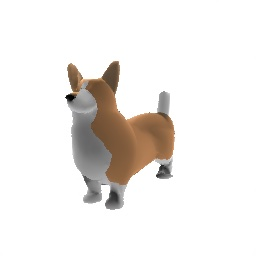

In [24]:
# Load an image to condition on.
img = Image.open('/content/point-e/point_e/examples/example_data/corgi.jpg')
img

## Inference

In [25]:
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
  samples = x

0it [00:00, ?it/s]

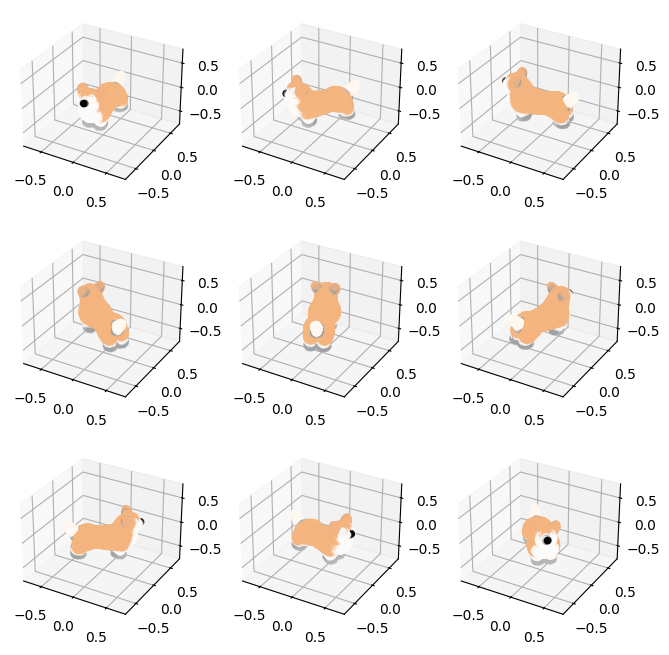

In [26]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

# Text to PointCloud

## 学習済みモデルのセットアップ

In [27]:
print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [28]:
sampler = PointCloudSampler(
  device=device,
  models=[base_model, upsampler_model],
  diffusions=[base_diffusion, upsampler_diffusion],
  num_points=[1024, 4096 - 1024],
  aux_channels=['R', 'G', 'B'],
  guidance_scale=[3.0, 0.0],
  model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

## Inference

In [64]:
# Set a prompt to condition on.
prompt = 'wardrobe' # @param {type:"string"}

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
  samples = x

0it [00:00, ?it/s]

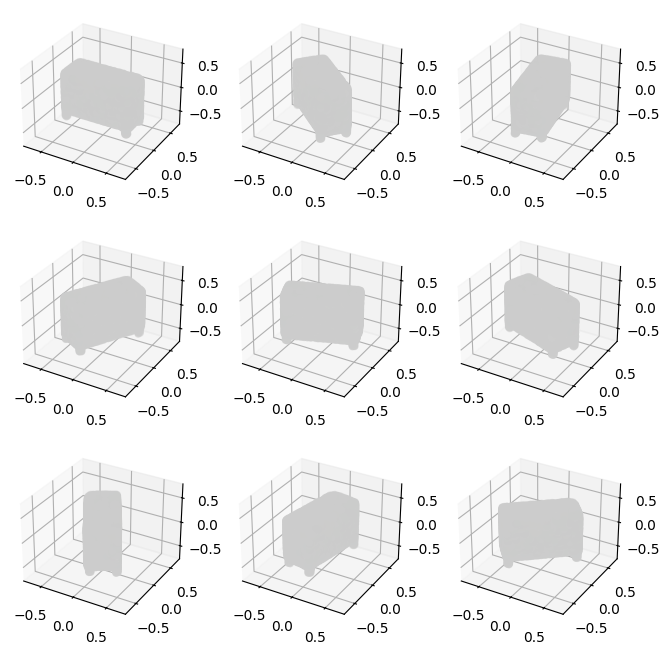

In [65]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [66]:
fig_plotly = go.Figure(
  data=[
    go.Scatter3d(
      x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2],
      mode='markers',
      marker=dict(
        size=2,
        color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
      )
    )
  ],
  layout=dict(
    scene=dict(
      xaxis=dict(visible=False),
      yaxis=dict(visible=False),
      zaxis=dict(visible=False)
    )
  ),
)

In [67]:
fig_plotly.show(renderer="colab")

In [68]:
pc = sampler.output_to_point_clouds(samples)[0]

with open('wardrobe.ply', 'wb') as plz:
  pc.write_ply(plz)


# PointCloud to Mesh

## 学習済みモデルのセットアップ

In [17]:
print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


  0%|          | 0.00/38.0M [00:00<?, ?iB/s]

/content/point-e/point_e/models/download.py:78: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

## PointCloudのセットアップ

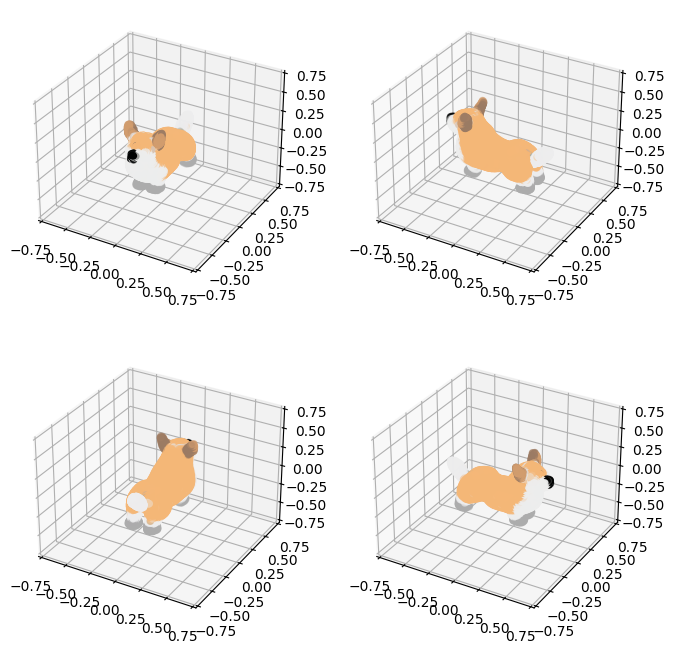

In [18]:
# Load a point cloud we want to convert into a mesh.
pc = PointCloud.load('/content/point-e/point_e/examples/example_data/pc_cube_stack.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(pc, grid_size=2)

## Inference

In [19]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
  pc=pc,
  model=model,
  batch_size=4096,
  grid_size=32, # increase to 128 for resolution used in evals
  progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
# Write the mesh to a PLY file to import into some other program.
with open('mesh.ply', 'wb') as f:
  mesh.write_ply(f)